In [119]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/black-friday-sales-prediction/sample_submission_V9Inaty.csv
/kaggle/input/black-friday-sales-prediction/train_oSwQCTC (1)/train.csv
/kaggle/input/black-friday-sales-prediction/test_HujdGe7 (1)/test.csv


**Analytics Vidhya: Black Friday Sales Prediction**

A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month. The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

**Variables Definition**

User_ID- User ID

Product_ID - Product ID

Gender - Sex of User

Age - Age in bins

Occupation - Occupation (Masked)

City_Category - Category of the City (A,B,C)

Stay_In_Current_City_Years - Number of years stay in current city

Marital_Status - Marital Status

Product_Category_1 - Product Category (Masked)

Product_Category_2 - Product may belongs to other category also (Masked)

Product_Category_3 - Product may belongs to other category also (Masked)

Purchase - Purchase Amount (Target Variable)

In [120]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
np.random.seed(42)

from scipy import stats
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [121]:
train_data = pd.read_csv('../input/black-friday-sales-prediction/train_oSwQCTC (1)/train.csv')
test_data = pd.read_csv('../input/black-friday-sales-prediction/test_HujdGe7 (1)/test.csv')
train_data.columns = train_data.columns.str.strip().str.lower().str.replace(' ', '_')
test_data.columns = test_data.columns.str.strip().str.lower().str.replace(' ', '_')
print('Train Data shape: ', train_data.shape)
train_data.head()

Train Data shape:  (550068, 12)


,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [122]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     550068 non-null  int64  
 1   product_id                  550068 non-null  object 
 2   gender                      550068 non-null  object 
 3   age                         550068 non-null  object 
 4   occupation                  550068 non-null  int64  
 5   city_category               550068 non-null  object 
 6   stay_in_current_city_years  550068 non-null  object 
 7   marital_status              550068 non-null  int64  
 8   product_category_1          550068 non-null  int64  
 9   product_category_2          376430 non-null  float64
 10  product_category_3          166821 non-null  float64
 11  purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [123]:
train_data.describe()

,user_id,occupation,marital_status,product_category_1,product_category_2,product_category_3,purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


**Checking for Null values**

In [124]:
train_data.isnull().sum()

user_id                            0
product_id                         0
gender                             0
age                                0
occupation                         0
city_category                      0
stay_in_current_city_years         0
marital_status                     0
product_category_1                 0
product_category_2            173638
product_category_3            383247
purchase                           0
dtype: int64

In [125]:
Total = train_data.isnull().sum().sort_values(ascending=False)          
Percent = (train_data.isnull().sum()*100/train_data.isnull().count()).sort_values(ascending=False)   

missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data

,Total,Percentage of Missing Values
product_category_3,383247,69.672659
product_category_2,173638,31.566643
user_id,0,0.000000
product_id,0,0.000000
gender,0,0.000000
age,0,0.000000
occupation,0,0.000000
city_category,0,0.000000
stay_in_current_city_years,0,0.000000
marital_status,0,0.000000


In [126]:
train_data['type'] = 'train'
test_data['type'] = 'test'

master_data = pd.concat([train_data, test_data])
master_data.head()

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,purchase,type
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370.0,train
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0,train
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422.0,train
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057.0,train
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969.0,train


**Exploratory Data Analysis**

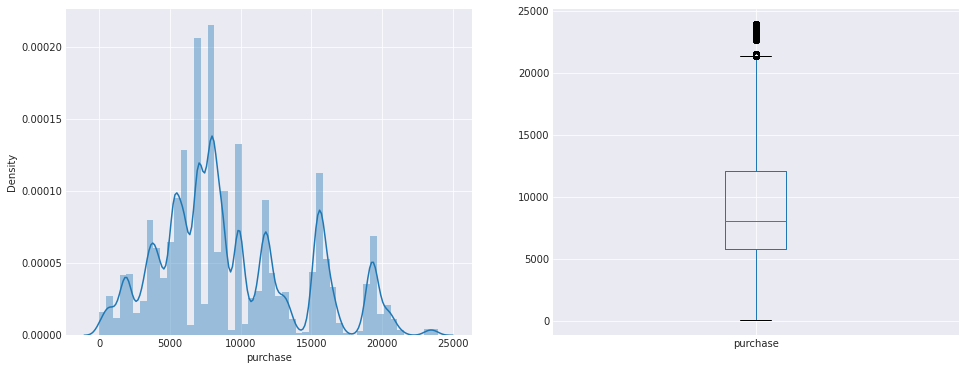

In [127]:
plt.figure(1)
plt.subplot(121)
sns.distplot(master_data["purchase"]);

plt.subplot(122)
master_data["purchase"].plot.box(figsize = (16, 6))
plt.show()

**Purchase has unequal distribution**

M    590031
F    193636
Name: gender, dtype: int64


<AxesSubplot:title={'center':'Gender'}>

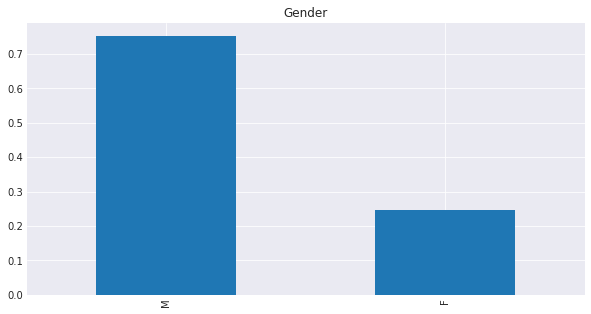

In [128]:
plt.figure(figsize = (10, 5))
print(master_data["gender"].value_counts())
master_data['gender'].value_counts(normalize = True).plot.bar(title = 'Gender')

**There are more males than females**

26-35    313015
36-45    156724
18-25    141953
46-50     65278
51-55     54784
55+       30579
0-17      21334
Name: age, dtype: int64


<AxesSubplot:title={'center':'Age'}>

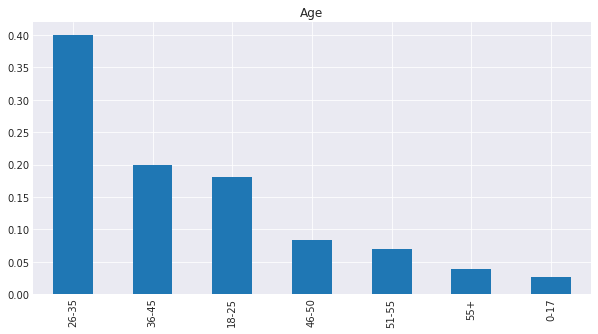

In [129]:
plt.figure(figsize = (10, 5))
print(master_data["age"].value_counts())
master_data['age'].value_counts(normalize = True).plot.bar(title = 'Age')

**26-35 age group people has the highest count**

1     276425
2     145427
3     135428
4+    120671
0     105716
Name: stay_in_current_city_years, dtype: int64


<AxesSubplot:title={'center':'Stay in current city - Years'}>

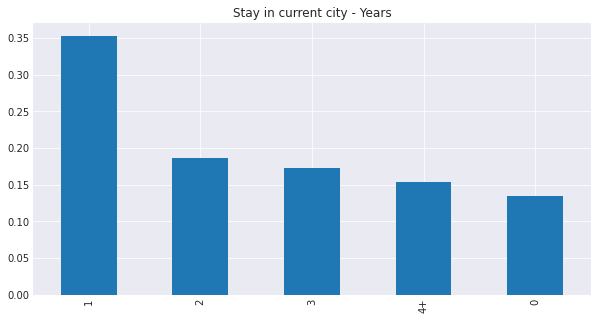

In [130]:
plt.figure(figsize = (10, 5))
print(master_data["stay_in_current_city_years"].value_counts())
master_data['stay_in_current_city_years'].value_counts(normalize = True).plot.bar(title = 'Stay in current city - Years')

**Maximum people stay in current city for 1 year**

4     103086
0      98850
7      84127
1      67687
17     57418
20     47840
12     44448
14     38782
2      37996
16     36122
6      29102
3      25126
10     18304
5      17373
15     17356
11     16593
19     11919
13     11053
18      9367
9       8929
8       2189
Name: occupation, dtype: int64


<AxesSubplot:title={'center':'Occupation'}>

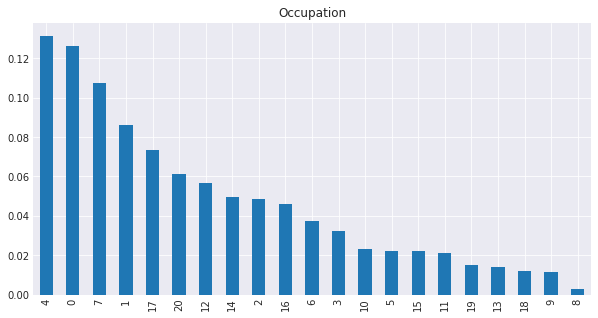

In [131]:
plt.figure(figsize = (10, 5))
print(master_data["occupation"].value_counts())
master_data['occupation'].value_counts(normalize = True).plot.bar(title = 'Occupation')

B    329739
C    243684
A    210244
Name: city_category, dtype: int64


<AxesSubplot:title={'center':'City Category'}>

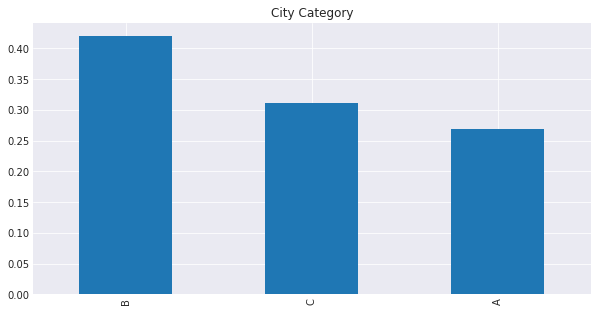

In [132]:
plt.figure(figsize = (10, 5))
print(master_data["city_category"].value_counts())
master_data['city_category'].value_counts(normalize = True).plot.bar(title = 'City Category')

**Category B city has the highest count**

0    462538
1    321129
Name: marital_status, dtype: int64


<AxesSubplot:title={'center':'Martial Status'}>

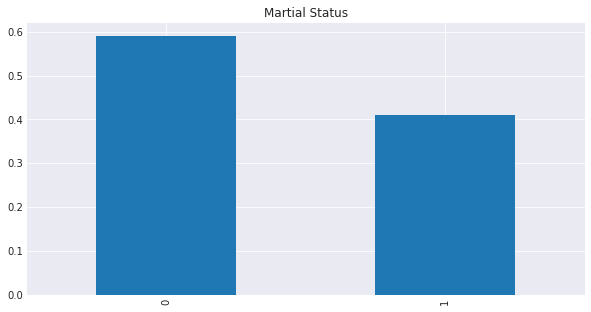

In [133]:
plt.figure(figsize = (10, 5))
print(master_data["marital_status"].value_counts())
master_data['marital_status'].value_counts(normalize = True).plot.bar(title = 'Martial Status')

**Maximum people have not married yet**

5     215950
1     200699
8     162294
11     34440
2      34056
6      29326
3      28791
4      16756
16     13933
15      8984
13      7930
10      7373
12      5610
7       5345
18      4436
20      2550
14      2186
19      1603
17       801
9        604
Name: product_category_1, dtype: int64


<AxesSubplot:title={'center':'Product Category 1'}>

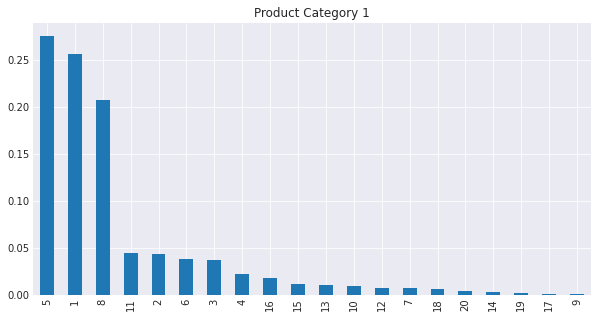

In [134]:
plt.figure(figsize = (10, 5))
print(master_data["product_category_1"].value_counts())
master_data['product_category_1'].value_counts(normalize = True).plot.bar(title = 'Product Category 1')

8.0     91317
14.0    78834
2.0     70498
16.0    61687
15.0    54114
5.0     37165
4.0     36705
6.0     23575
11.0    20230
17.0    19104
13.0    15054
9.0      8177
12.0     7801
10.0     4420
3.0      4123
18.0     4027
7.0       854
Name: product_category_2, dtype: int64


<AxesSubplot:title={'center':'Product Category 2'}>

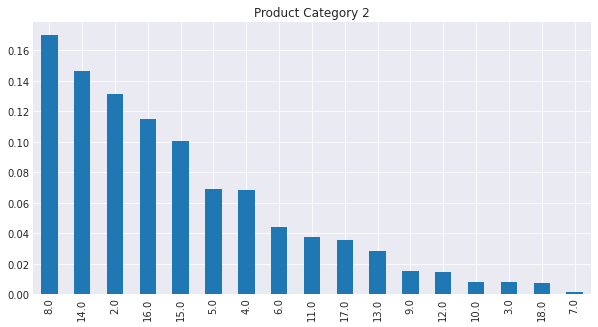

In [135]:
plt.figure(figsize = (10, 5))
print(master_data["product_category_2"].value_counts())
master_data['product_category_2'].value_counts(normalize = True).plot.bar(title = 'Product Category 2')

16.0    46469
15.0    39968
14.0    26283
17.0    23818
5.0     23799
8.0     17861
9.0     16532
12.0    13115
13.0     7849
6.0      6888
18.0     6621
4.0      2691
11.0     2585
10.0     2501
3.0       878
Name: product_category_3, dtype: int64


<AxesSubplot:title={'center':'Product Category 3'}>

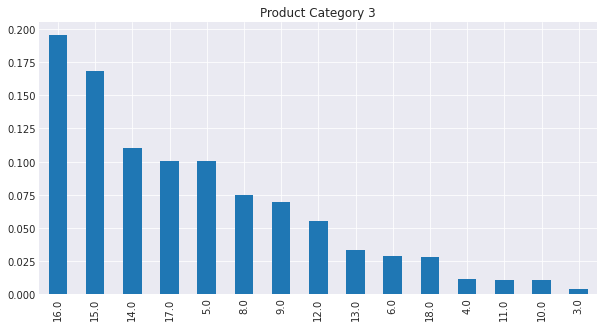

In [136]:
plt.figure(figsize = (10, 5))
print(master_data["product_category_3"].value_counts())
master_data['product_category_3'].value_counts(normalize = True).plot.bar(title = 'Product Category 3')

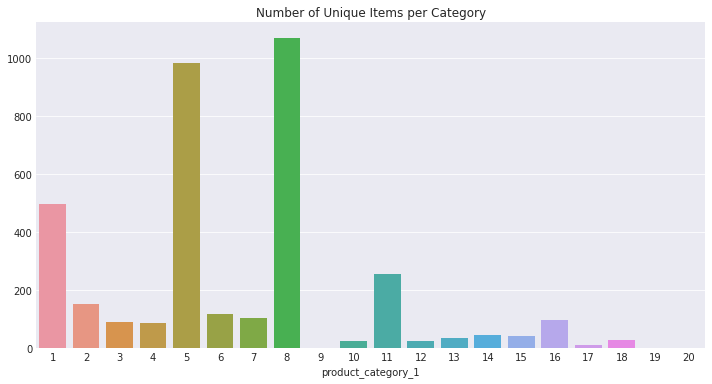

In [137]:
plt.figure(figsize = (12, 6))
prod_by_cat = master_data.groupby('product_category_1')['product_id'].nunique()

sns.barplot(x = prod_by_cat.index,y = prod_by_cat.values)
plt.title('Number of Unique Items per Category')
plt.show()

<AxesSubplot:xlabel='city_category', ylabel='purchase'>

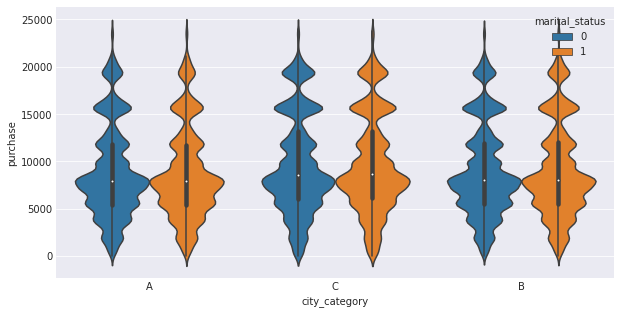

In [138]:
plt.figure(figsize = (10, 5))
sns.violinplot(x = 'city_category', y = 'purchase', hue = 'marital_status', data = master_data)

**Almost all the city categories have equal proportion of males and females**

Text(0.5, 1.0, 'Age & Gender')

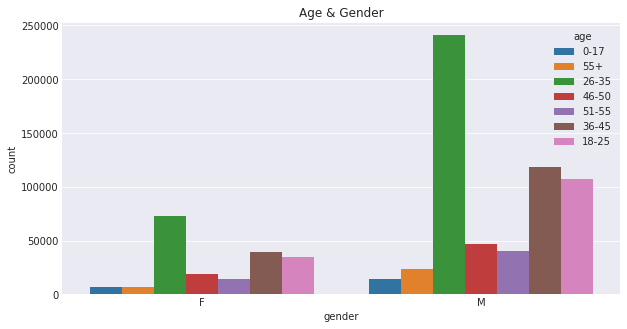

In [139]:
plt.figure(figsize = (10, 5))
sns.countplot(master_data["gender"], hue = master_data["age"]).set_title("Age & Gender")

**26-35 age group people with respect to Males is the highest also females in that age group is also the highest.**

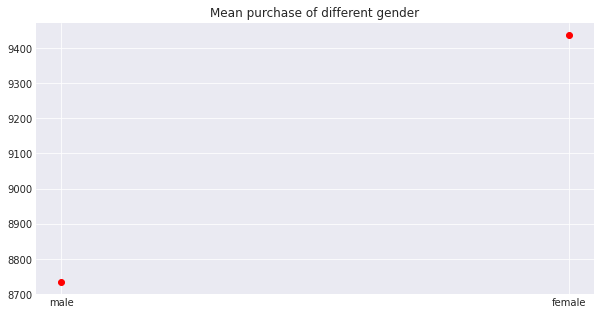

In [140]:
plt.figure(figsize = (10, 5))
x = master_data.groupby(["gender"]).mean()[["purchase"]].index
y = master_data.groupby(["gender"]).mean()[["purchase"]].values
plt.plot(x, y,"ro")
plt.xticks(x, ["male", "female"])
plt.title("Mean purchase of different gender")
sns.despine()

**Females have higher mean purchases compared to males**

<AxesSubplot:title={'center':'City Categry'}, ylabel='purchase'>

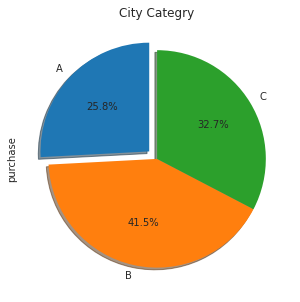

In [141]:
plt.figure(figsize = (10, 5))
master_data.groupby("city_category")["purchase"].sum().plot.pie(title = "City Categry", 
                                                               startangle = 90, explode = (0.1, 0, 0), 
                                                               autopct = "%1.1f%%", shadow = True)

Text(0.5, 1.0, 'Mean purchase of different city categories')

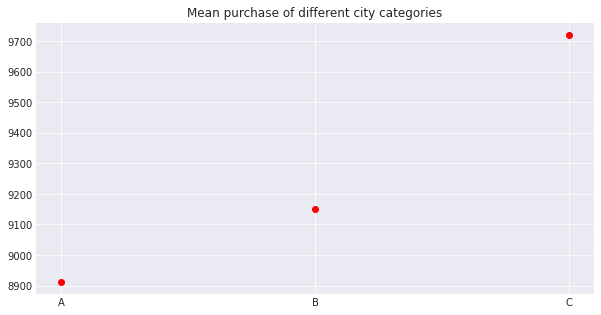

In [142]:
plt.figure(figsize = (10, 5))
x = master_data.groupby(["city_category"]).mean()[["purchase"]].index
y = master_data.groupby(["city_category"]).mean()[["purchase"]].values
plt.plot(x, y,"ro")
plt.title("Mean purchase of different city categories")

**Category city C has the highest mean purchase.**

<AxesSubplot:title={'center':'Years of staying in the city'}, ylabel='stay_in_current_city_years'>

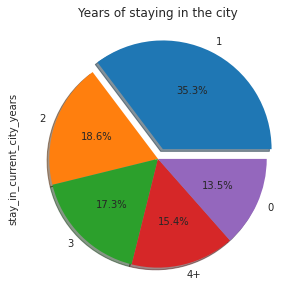

In [143]:
plt.figure(figsize = (10, 5))
master_data["stay_in_current_city_years"].value_counts().plot.pie(title = "Years of staying in the city", 
                                                                 explode = (0.1, 0, 0, 0, 0), 
                                                                 autopct = "%1.1f%%", shadow = True)

**Data Preprocessing**

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
train_data['user_id'] = train_data['user_id'] - 1000000
test_data['user_id'] = test_data['user_id'] - 1000000

enc = LabelEncoder()
train_data['user_id'] = enc.fit_transform(train_data['user_id'])
test_data['user_id'] = enc.transform(test_data['user_id'])

In [145]:
train_data['product_id'] = train_data['product_id'].str.replace('P00', '')
test_data['product_id'] = test_data['product_id'].str.replace('P00', '')

scaler = StandardScaler()
train_data['product_id'] = scaler.fit_transform(train_data['product_id'].values.reshape(-1, 1))
test_data['product_id'] = scaler.transform(test_data['product_id'].values.reshape(-1, 1))

In [146]:
categorical_col = ['gender', 'city_category']
numerical_col = ['age', 'occupation', 'stay_in_current_city_years', 'product_category_1', 'product_category_2', 'product_category_3']

In [147]:
train_data['age']=train_data['age'].replace('0-17',17)
train_data['age']=train_data['age'].replace('18-25',25)
train_data['age']=train_data['age'].replace('26-35',35)
train_data['age']=train_data['age'].replace('36-45',45)
train_data['age']=train_data['age'].replace('46-50',50)
train_data['age']=train_data['age'].replace('51-55',55)
train_data['age']=train_data['age'].replace('55+',60)

In [148]:
test_data['age']=test_data['age'].replace('0-17',17)
test_data['age']=test_data['age'].replace('18-25',25)
test_data['age']=test_data['age'].replace('26-35',35)
test_data['age']=test_data['age'].replace('36-45',45)
test_data['age']=test_data['age'].replace('46-50',50)
test_data['age']=test_data['age'].replace('51-55',55)
test_data['age']=test_data['age'].replace('55+',60)

In [149]:
train_data['stay_in_current_city_years']=train_data['stay_in_current_city_years'].replace('4+',4)
test_data['stay_in_current_city_years']=test_data['stay_in_current_city_years'].replace('4+',4)

**Imputing null values**

In [150]:
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

**Encoding categorical columns**

In [151]:
encoder = LabelEncoder()

for col in categorical_col:
    train_data[col] = encoder.fit_transform(train_data[col])
    test_data[col] = encoder.transform(test_data[col])

**Scaling numerical columns**

In [152]:
scaler = StandardScaler()

for col in numerical_col:
    train_data[col] = scaler.fit_transform(train_data[col].values.reshape(-1, 1))
    test_data[col] = scaler.transform(test_data[col].values.reshape(-1, 1))

In [153]:
train_data

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,purchase,type
0,0,-1.028774,0,-2.059570,0.294864,0,0.109801,0,-0.610809,-1.083654,-0.614641,8370,train
1,0,0.722139,0,-2.059570,0.294864,0,0.109801,0,-1.118912,-0.118323,1.625106,15200,train
2,0,-0.845799,0,-2.059570,0.294864,0,0.109801,0,1.675656,-1.083654,-0.614641,1422,train
3,0,-0.869157,0,-2.059570,0.294864,0,0.109801,0,1.675656,1.168785,-0.614641,1057,train
4,1,1.077382,1,2.094842,1.214734,2,1.660861,0,0.659449,-1.083654,-0.614641,7969,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,5883,1.924156,1,1.611771,0.754799,1,-0.665728,1,3.708069,-1.083654,-0.614641,368,train
550064,5885,1.953267,0,-0.320514,-1.084943,2,0.885331,0,3.708069,-1.083654,-0.614641,371,train
550065,5886,1.953267,0,-0.320514,1.061423,1,1.660861,1,3.708069,-1.083654,-0.614641,137,train
550066,5888,1.953267,0,2.094842,-1.084943,2,0.109801,0,3.708069,-1.083654,-0.614641,365,train


In [154]:
X_train.drop(['type'], axis = 1)

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3
178247,3478,0.575175,1,1.611771,-0.165072,1,0.885331,1,-1.118912,1.329673,-0.614641
196647,336,-0.338725,1,-1.286656,0.601487,2,1.660861,0,-0.102705,-1.083654,-0.614641
418590,4273,1.124099,1,-0.320514,-0.471696,1,-0.665728,0,0.659449,1.168785,2.105051
408727,2852,0.975189,1,-1.286656,-0.625007,1,0.109801,0,0.659449,-1.083654,-0.614641
216416,3340,-1.219535,1,-1.286656,-0.625007,1,-0.665728,0,-1.118912,0.203454,-0.614641
...,...,...,...,...,...,...,...,...,...,...,...
110268,4868,-1.305182,1,1.128700,1.368046,2,0.109801,0,-0.102705,-1.083654,-0.614641
259178,3820,-1.481344,1,-0.320514,0.908111,2,0.109801,1,-0.102705,-1.083654,-0.614641
365838,2190,1.404401,0,-1.286656,-1.084943,1,-0.665728,0,-0.102705,-1.083654,-0.614641
131932,2195,-1.683784,0,-1.286656,-0.625007,1,0.109801,0,0.659449,1.168785,-0.614641


In [155]:
X_val.drop(['type'], axis = 1)

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3
84432,1026,1.718767,1,1.611771,1.674670,2,0.885331,0,-1.118912,-0.761877,1.945069
72724,5043,0.611186,0,0.645628,0.448175,1,-0.665728,0,-1.118912,1.329673,1.945069
197032,407,-0.569390,0,0.645628,-1.238255,0,0.109801,1,0.659449,1.329673,-0.614641
353704,484,-1.537794,1,-1.286656,-0.625007,0,0.885331,0,-1.118912,1.329673,1.945069
91198,1953,-1.678918,1,-1.286656,-0.625007,1,-1.441258,0,0.151346,0.203454,1.945069
...,...,...,...,...,...,...,...,...,...,...,...
133324,2473,-0.620974,1,2.094842,0.754799,1,0.109801,1,-1.118912,-0.761877,-0.614641
138718,3368,-1.503729,0,-0.320514,-0.625007,1,0.885331,0,0.659449,1.168785,-0.614641
22886,3488,0.035010,1,0.645628,1.827982,0,0.109801,1,0.659449,-1.083654,-0.614641
137110,3119,1.456958,1,0.645628,-0.165072,0,-1.441258,0,1.421604,1.007896,1.945069


**Splitting the dataset**

In [162]:
X = train_data.drop(['purchase','type'], axis=1)
y = train_data[['purchase']]
X_test = test_data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [163]:
train_data.columns

Index(['user_id', 'product_id', 'gender', 'age', 'occupation', 'city_category',
       'stay_in_current_city_years', 'marital_status', 'product_category_1',
       'product_category_2', 'product_category_3', 'purchase', 'type'],
      dtype='object')

In [105]:
train_data.drop(['type'], axis = 1)

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3,purchase
0,0,-1.028774,0,-2.059570,0.294864,0,0.109801,0,-0.610809,-1.083654,-0.614641,8370
1,0,0.722139,0,-2.059570,0.294864,0,0.109801,0,-1.118912,-0.118323,1.625106,15200
2,0,-0.845799,0,-2.059570,0.294864,0,0.109801,0,1.675656,-1.083654,-0.614641,1422
3,0,-0.869157,0,-2.059570,0.294864,0,0.109801,0,1.675656,1.168785,-0.614641,1057
4,1,1.077382,1,2.094842,1.214734,2,1.660861,0,0.659449,-1.083654,-0.614641,7969
...,...,...,...,...,...,...,...,...,...,...,...,...
550063,5883,1.924156,1,1.611771,0.754799,1,-0.665728,1,3.708069,-1.083654,-0.614641,368
550064,5885,1.953267,0,-0.320514,-1.084943,2,0.885331,0,3.708069,-1.083654,-0.614641,371
550065,5886,1.953267,0,-0.320514,1.061423,1,1.660861,1,3.708069,-1.083654,-0.614641,137
550066,5888,1.953267,0,2.094842,-1.084943,2,0.109801,0,3.708069,-1.083654,-0.614641,365


In [158]:
y_train

,purchase
178247,7800
196647,8677
418590,7966
408727,9852
216416,15804
...,...
110268,1862
259178,8623
365838,6954
131932,6151


In [159]:
X_val.columns

Index(['user_id', 'product_id', 'gender', 'age', 'occupation', 'city_category',
       'stay_in_current_city_years', 'marital_status', 'product_category_1',
       'product_category_2', 'product_category_3', 'type'],
      dtype='object')

In [160]:
X_val.drop(['type'], axis = 1)

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category_1,product_category_2,product_category_3
84432,1026,1.718767,1,1.611771,1.674670,2,0.885331,0,-1.118912,-0.761877,1.945069
72724,5043,0.611186,0,0.645628,0.448175,1,-0.665728,0,-1.118912,1.329673,1.945069
197032,407,-0.569390,0,0.645628,-1.238255,0,0.109801,1,0.659449,1.329673,-0.614641
353704,484,-1.537794,1,-1.286656,-0.625007,0,0.885331,0,-1.118912,1.329673,1.945069
91198,1953,-1.678918,1,-1.286656,-0.625007,1,-1.441258,0,0.151346,0.203454,1.945069
...,...,...,...,...,...,...,...,...,...,...,...
133324,2473,-0.620974,1,2.094842,0.754799,1,0.109801,1,-1.118912,-0.761877,-0.614641
138718,3368,-1.503729,0,-0.320514,-0.625007,1,0.885331,0,0.659449,1.168785,-0.614641
22886,3488,0.035010,1,0.645628,1.827982,0,0.109801,1,0.659449,-1.083654,-0.614641
137110,3119,1.456958,1,0.645628,-0.165072,0,-1.441258,0,1.421604,1.007896,1.945069


**Model Building**

In [164]:
from sklearn import linear_model
reg=linear_model.LinearRegression()
lm_model=reg.fit(X_train,y_train)
pred=lm_model.predict(X_val)

In [165]:
np.sqrt(mean_squared_error(y_val,pred))

4609.769799176727

In [166]:
xgb_reg = XGBRegressor(learning_rate=1.0, max_depth=6, min_child_weight=40, seed=0)

xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_pred, y_val))

print (xgb_reg)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1.0, max_delta_step=0, max_depth=6,
             min_child_weight=40, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [181]:
rmse

2591.851957429727

**We are getting an root mean square error of 2591.85.**

****XG Boost model is performing well with the above hyperparameters compared to Linear Regression.****